In [1]:
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager
# !jupyter nbextension enable --py widgetsnbextension
# !pip install plotly
# !pip install ipywidgets
# !pip install ipypivot
# !conda install nodejs --y

# !pip install xgboost

<br>

#### Import Libraries

In [65]:
import numpy as np
from PIL import Image
import time
import functools

import os
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import SelectKBest

from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

from sklearn import svm
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.externals import joblib

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer

import matplotlib.pyplot
#jupyter labextension install @jupyterlab/plotly-extension
import plotly
import plotly.graph_objs as go
import plotly.figure_factory as ff

import xgboost as xgb

plotly.offline.init_notebook_mode(connected=True)


<br>

#### Custom Functions

In [66]:
def scale_data(df):
    from sklearn.preprocessing import StandardScaler
    numeric_df = df._get_numeric_data()
    scaler = StandardScaler()
    scaler.fit(numeric_df)
    StandardScaler(copy=True)
    scaled_df = pd.DataFrame(scaler.transform(numeric_df))
    scaled_df.columns = numeric_df.columns
    return scaled_df

In [67]:
def random_forest_feature_importance(scaled_df, label_df):
    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=500, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
    rf.fit(scaled_df, label_df)
    features = scaled_df.columns.values
    
    x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), 
                                                            reverse = False)))
    trace2 = go.Bar(
        x=x ,
        y=y,
        marker=dict(
            color=x,
            colorscale = 'Viridis',
            reversescale = True
        ),
        name='Random Forest Feature importance',
        orientation='h',
    )

    layout = dict(
        title='Barplot of Feature importances',
         width = 500, height = 500,
        yaxis=dict(
            showgrid=False,
            showline=False,
            showticklabels=True,
        ))

    fig1 = go.Figure(data=[trace2])
    fig1['layout'].update(layout)
    plotly.offline.iplot(fig1)

    

<br>

#### Importing Data - local csv

In [68]:
os.chdir('/Users/al/documents/datascience/datasets/historical-punt-return-data/')
file_list = list(os.listdir())
file_list.remove('best_pipeline.pkl')
#test_df = pd.read_csv('1976_Returns.csv')
#test_df['year'] = 1976
print(file_list)

cnt = 0

for file in file_list:

    cnt += 1
    
    temp_df = pd.read_csv(file)
    temp_df['year'] = file[:4]
    
    if cnt == 1:
        
        df = temp_df
        
    else:
        
        df = df.append(temp_df)
        
    print(df.shape)

df = df.drop(['Rk'], axis=1)
df.columns = ['player','team','age','position','games','starts','returns','yards','td','long','yards_ret','year']


['1974_Returns.csv', '1971_Returns.csv', '1972_Returns.csv', '1975_Returns.csv', '1976_Returns.csv', '1973_Returns.csv']
(253, 13)
(497, 13)
(717, 13)
(951, 13)
(1217, 13)
(1451, 13)


In [69]:
def cat_prep(df, cat_list):
    
    cat_df = df[cat_list]
    
    for cat in cat_list:
        cat_df.loc[cat_df[cat].str.contains('/') == True, cat] = 'NA'
        cat_df[cat] = cat_df[cat].fillna('miss')
        cat_df[cat] = cat_df[cat].str.lower()
        cat_df[cat] = cat_df[cat].astype('category')
        
    return cat_df

def preproc_df(df, fn):
    new_df = []
    for col in df.columns:
        new_df.append(fn(df[col]))
    return new_df


def mbin(x):
    mlb = MultiLabelBinarizer()
    x = mlb.fit_transform(x.str.split(', '))
    x = pd.DataFrame(x, columns = list(mlb.classes_))
    return x

def agg_fn(df, group_cols, col, fn):
    temp_df = pd.DataFrame(df.groupby(group_cols)[col].agg(fn).reset_index())
    temp_cols = group_cols.copy()
    temp_cols.extend([(str(col) + '_' + str(fn) )])
    temp_df.columns = list(temp_cols)
    return temp_df

def create_agg_df(df, group_cols, cols, fn):
    
    new_df = df[group_cols].drop_duplicates()
    cnt = 0
    for col in cols:
        cnt += 1
        agg_df = agg_fn(df, group_cols, col, fn)
        new_df = pd.merge(new_df, agg_df, 
                          left_on = (group_cols), 
                          right_on = (group_cols),
                          how = 'left')
    return new_df

In [70]:
def data_pipeline(df):
    
    cat_list = ['team','position']
    cat_df = cat_prep(df, cat_list)

    onehot_df = preproc_df(cat_df, mbin)
    
    group_cols = ['year','team']

    team_yr_df = pd.DataFrame(df[group_cols].drop_duplicates())
    
    sum_cols = ['returns','yards','yards_ret']
    sum_df = create_agg_df(df, group_cols, sum_cols, 'sum')
    
    min_cols = ['age','starts']
    min_df = create_agg_df(df, group_cols, min_cols, 'min')

    max_cols = ['age','starts','long']
    max_df = create_agg_df(df, group_cols, max_cols, 'max')

    label_cols = ['td']
    label_df = create_agg_df(df, group_cols, label_cols, 'sum')
    
    df_list = [sum_df, min_df, max_df, label_df]
    
    new_df = df[group_cols]

    for items in onehot_df:
        new_df = pd.merge(new_df, pd.DataFrame(items), left_index=True, right_index=True)

    model_df = pd.DataFrame(new_df.groupby(group_cols).agg('max').reset_index())

    for data in df_list:
        model_df = pd.merge(model_df, data, left_on = group_cols, right_on = group_cols, how = 'left')
    
    model_df = model_df.drop(['long_max','returns_sum', 'yards_sum', 'yards_ret_sum'], axis=1)
    
    qa_df = model_df[model_df['year'] == '1976']
    model_df = model_df[model_df['year'] != '1976']
    
    qa_df = qa_df.drop(['year','team'], axis=1)
    model_df = model_df.drop(['year','team'], axis=1)
    
    
        
    return model_df, qa_df

In [71]:
model_df, qa_df = data_pipeline(df)

print(model_df.shape)
print(qa_df.shape)

(136, 69)
(30, 69)


In [72]:
df = model_df

col_list = list(df.columns)
label = 'td_sum'
features = [col for col in df.columns if col not in [label]]


In [73]:
label_type = 'set type'

if (pd.core.common.is_categorical_dtype(df[label])):
    label_type = 'categorical'
    
if (pd.core.common.is_numeric_dtype(df[label])):
    label_type = 'numerical'
    
print(label_type)


numerical


In [74]:
label_df = df[label]
feature_df = df[features]

label_df = label_df.fillna(0)
feature_df = feature_df.fillna(0)

print("Data Label: ", label)
print("Feature list: ", features)

if label_type == 'categorical':
    scaled_df = scale_data(feature_df)
if label_type == 'numerical':
    scaled_df = scale_data(feature_df.fillna(0))

Data Label:  td_sum
Feature list:  ['2tm', '3tm', '4tm', 'atl', 'bal', 'buf', 'chi', 'cin', 'cle', 'dal', 'den', 'det', 'gnb', 'hou', 'kan', 'mia', 'min', 'nor', 'nwe', 'nyg', 'nyj', 'oak', 'phi', 'pit', 'ram', 'sdg', 'sea', 'sfo', 'stl', 'tam', 'was', 'c', 'db', 'de', 'dt', 'fb', 'fs', 'kr', 'lb', 'lcb', 'lde', 'ldt', 'lg', 'llb', 'lolb', 'lt', 'miss', 'mlb', 'na', 'p', 'pr', 'rb', 'rcb', 'rde', 'rdt', 'rg', 'rilb', 'rlb', 'rolb', 'rt', 'ss', 't', 'te', 'wr', 'age_min', 'starts_min', 'age_max', 'starts_max']


In [75]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
label = encoder.fit_transform(label_df)

#(X_train, X_test, y_train, y_test) = train_test_split(feature_df, label, test_size=0.10, random_state=42)
(X_train, X_test, y_train, y_test) = train_test_split(scaled_df, label, test_size=0.10, random_state=42)

In [76]:
param_dist = {'objective':'count:poisson', 'n_estimators':10}

clf = xgb.XGBModel(**param_dist)

clf.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='logloss',
        verbose=True)

evals_result = clf.evals_result()

[0]	validation_0-logloss:0.643628	validation_1-logloss:0.672798
[1]	validation_0-logloss:0.604495	validation_1-logloss:0.651612
[2]	validation_0-logloss:0.574482	validation_1-logloss:0.631676
[3]	validation_0-logloss:0.548837	validation_1-logloss:0.616485
[4]	validation_0-logloss:0.514962	validation_1-logloss:0.607403
[5]	validation_0-logloss:0.495068	validation_1-logloss:0.60053
[6]	validation_0-logloss:0.47702	validation_1-logloss:0.592914
[7]	validation_0-logloss:0.452712	validation_1-logloss:0.589804
[8]	validation_0-logloss:0.437552	validation_1-logloss:0.586872
[9]	validation_0-logloss:0.425461	validation_1-logloss:0.579358


In [77]:
# evaluate predictions
from sklearn.metrics import accuracy_score

predictions = clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions.astype(int))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 92.86%


In [78]:
qa_col_list = list(qa_df.columns)
qa_label = 'td_sum'
qa_features = [col for col in qa_df.columns if col not in [qa_label]]

qa_label_df = qa_df[qa_label]
qa_feature_df = qa_df[qa_features]

qa_label_df = qa_label_df.fillna(0)
qa_feature_df = qa_feature_df.fillna(0)

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
qa_label = encoder.fit_transform(qa_label_df)

qa_scaled_df = scale_data(qa_feature_df.fillna(0))

qa_predictions = clf.predict(qa_scaled_df)
accuracy = accuracy_score(qa_label_df, qa_predictions.astype(int))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 73.33%


In [79]:
qa_pred_df = pd.DataFrame(list(qa_label_df), qa_predictions)
qa_pred_df = qa_pred_df.reset_index()
qa_pred_df.columns = ['prediction', 'actual']
qa_pred_df

,prediction,actual
0,0.290292,0.0
1,0.304561,0.0
2,0.342290,0.0
3,0.281760,0.0
4,0.218507,1.0
5,0.476745,0.0
6,0.259986,0.0
7,0.373519,0.0
8,0.359513,0.0
9,0.281060,4.0


<br>

### Partial dependence using Gradient Boosting

Training GBRT...
 done.
Convenience plot with ``partial_dependence_plots``


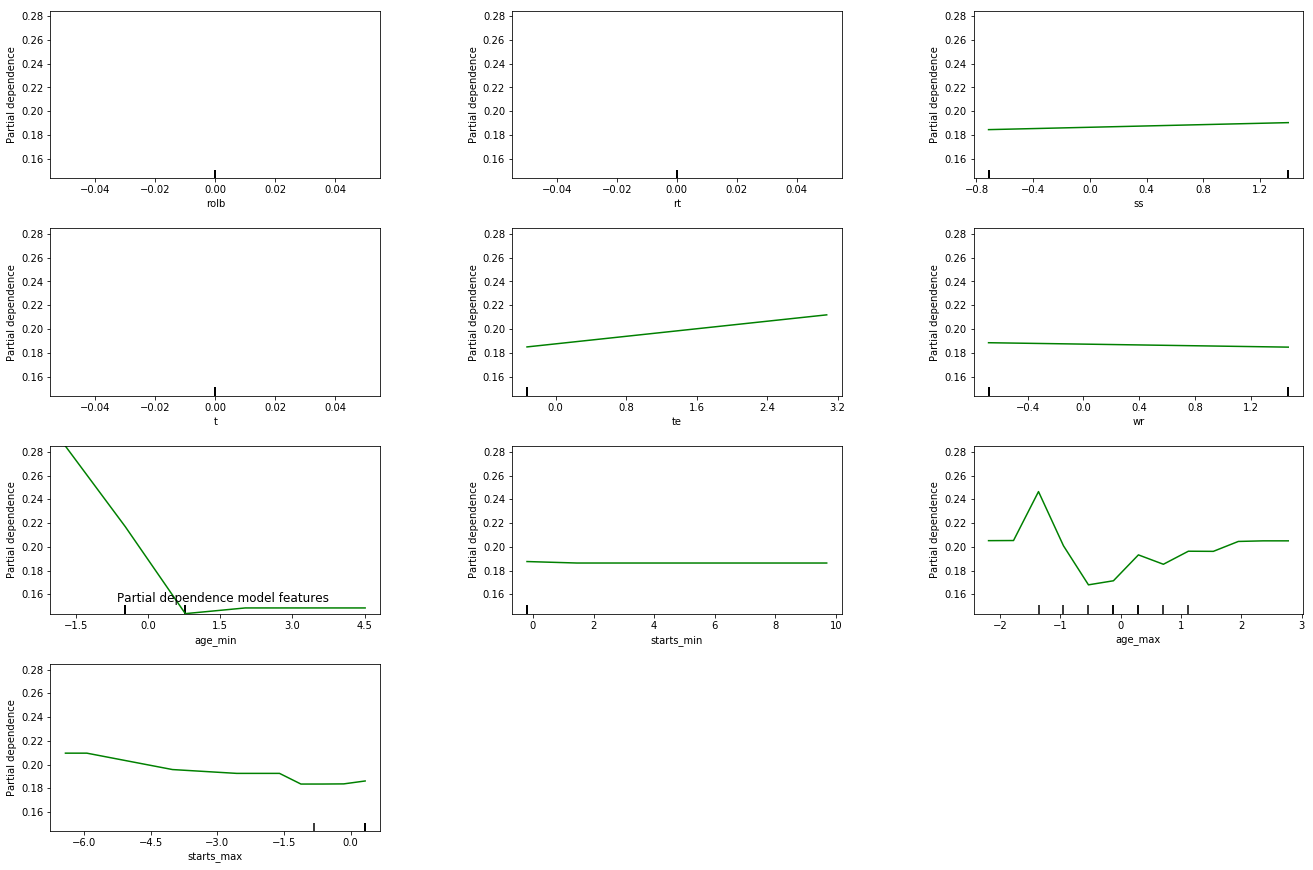

In [80]:
import matplotlib.pyplot as plt

names = feature_df.columns
feature_cnt = len(feature_df.columns)

print("Training GBRT...")
clf = GradientBoostingRegressor(n_estimators=200, max_depth=5,
                                learning_rate=0.01, loss='huber',
                                random_state=22)

clf.fit(X_train, y_train)
print(" done.")

print('Convenience plot with ``partial_dependence_plots``')

#features = [0, 5, 1, 2, (5, 1)]
features = list(range(58,feature_cnt))

fig, axs = plot_partial_dependence(clf, X_train, features,
                                   feature_names=names,
                                   n_jobs=5, grid_resolution=200)

fig.suptitle('Partial dependence model features')
plt.subplots_adjust(top=3,right=3)  # tight_layout causes overlap with suptitle

plt.show()

Custom 3d plot via ``partial_dependence``


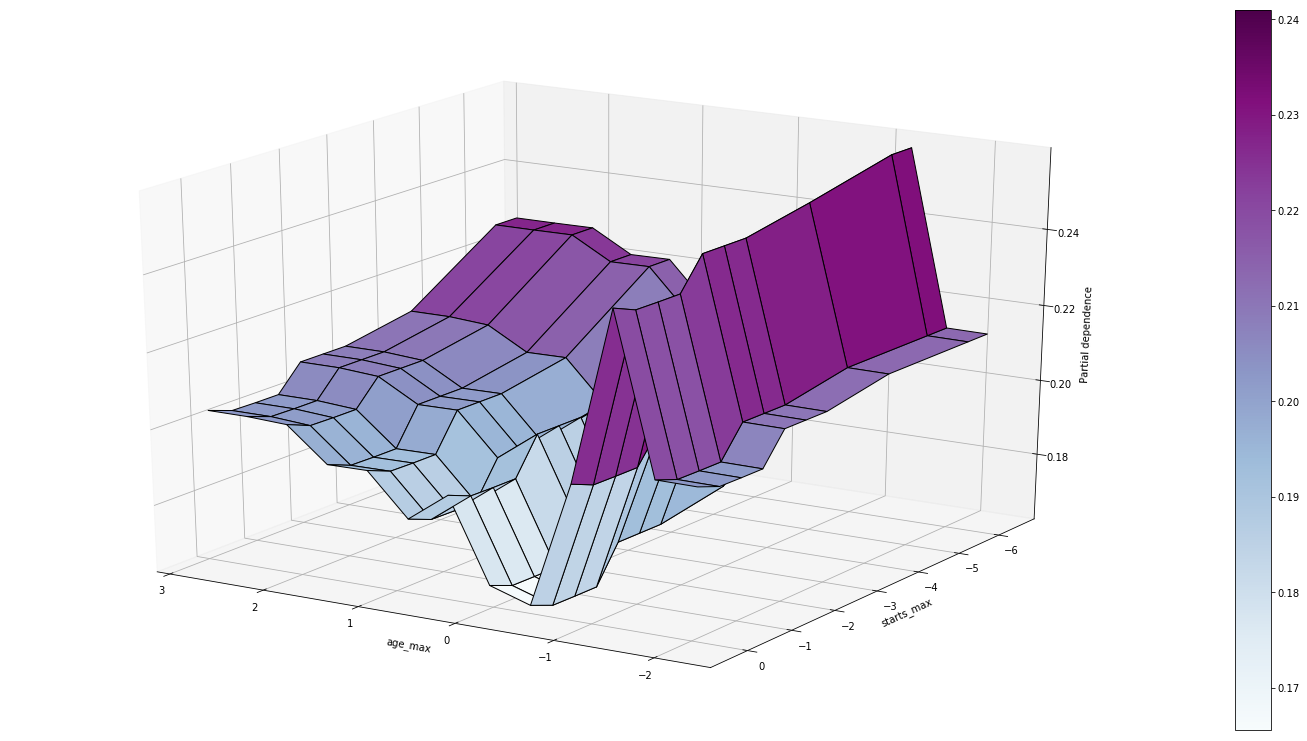

In [85]:
from mpl_toolkits.mplot3d import Axes3D

print('Custom 3d plot via ``partial_dependence``')

fig = plt.figure(figsize=(20,10))

target_feature = (66, 67)

pdp, axes = partial_dependence(clf, target_feature,
                               X=X_train, grid_resolution=200)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')

ax.set_xlabel(names[target_feature[0]])
ax.set_ylabel(names[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
#plt.suptitle('Analysis of ' + label)
plt.subplots_adjust(top=5,right=5)


plt.show()

Check MSE - testing set vs. predicted values

In [ ]:
y_pred = clf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE: %.4f" % mse)

<br>

## Simple basic model creation for S.a.G.
Do not use - simple model pipeline for demonstration
* Logistic Regression
* SVC
* Decision Tree
* Gradient Boosting

In [82]:
pipeline_poly = PolynomialFeatures(2)
# poly.fit_transform(X_train) 

# Scale data
pipeline_scaler = StandardScaler()

## PCA to reduce dimensionality
pipeline_pca = PCA(n_components=9)

## Polynomial Feature Generation
# poly = PolynomialFeatures(3)
# poly.fit_transform(X_train) 

# Construct some pipelines
pipe_lr = Pipeline([('scl', pipeline_scaler),('pca', pipeline_pca),('poly',pipeline_poly),('clf', LogisticRegression(random_state=42))])

pipe_svm = Pipeline([('scl', pipeline_scaler),('pca', pipeline_pca),('poly',pipeline_poly),('clf', svm.SVC(random_state=42))])

pipe_dt = Pipeline([('scl', pipeline_scaler),('pca', pipeline_pca),('poly',pipeline_poly),('clf', tree.DecisionTreeClassifier(random_state=42))])

pipe_gbr = Pipeline([('scl', pipeline_scaler),('pca', pipeline_pca),('poly',pipeline_poly),('clf', GradientBoostingRegressor( n_estimators=200, max_depth=15,learning_rate=0.01, 
                                                                                                      loss='huber', random_state=42))])


# List of pipelines for ease of iteration
pipelines = [pipe_lr, pipe_svm, pipe_dt, pipe_gbr]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Logistic Regression', 1: 'Support Vector Machine', 2: 'Decision Tree', 3: 'Gradient Boosted'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

# Compare accuracies
for idx, val in enumerate(pipelines):
    print('%s pipeline test accuracy: %.3f' % (pipe_dict[idx], val.score(X_test, y_test)))

# Identify the most accurate model on test data
best_acc = 0.0
best_clf = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
    if val.score(X_test, y_test) > best_acc:
        best_acc = val.score(X_test, y_test)
        best_pipe = val
        best_clf = idx
        
print('Classifier with best accuracy: %s' % pipe_dict[best_clf])

# Save pipeline to file
joblib.dump(best_pipe, 'best_pipeline.pkl', compress=1)
print('Saved %s pipeline to file' % pipe_dict[best_clf])

Logistic Regression pipeline test accuracy: 0.786
Support Vector Machine pipeline test accuracy: 0.929
Decision Tree pipeline test accuracy: 0.857
Gradient Boosted pipeline test accuracy: -4.853
Classifier with best accuracy: Support Vector Machine
Saved Support Vector Machine pipeline to file


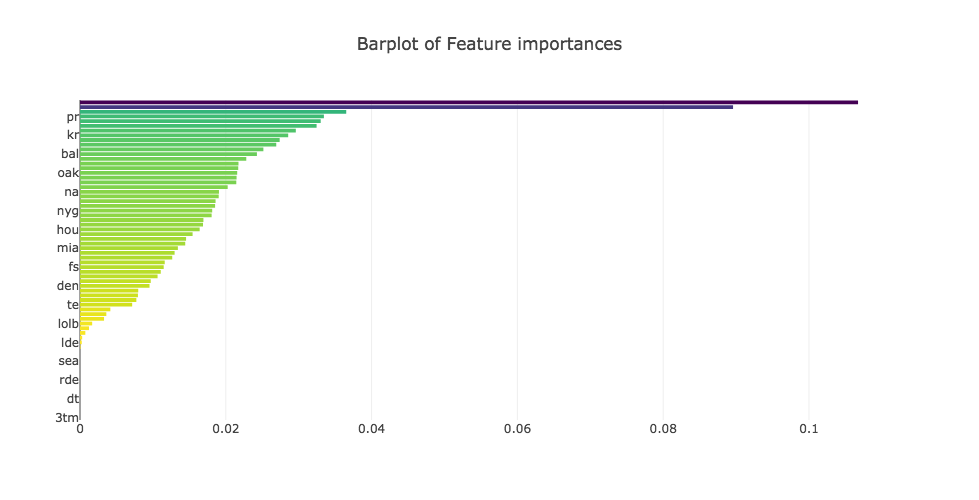

In [83]:
random_forest_feature_importance(scaled_df, label_df)